In [2]:
import pystan
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Colourblind friendly colours
cbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#999999"]

df = pd.read_csv("/home/zxy/Downloads/multistrain.csv")

subtypes = ["H1N1", "H2N3", "B"]

data_lst = {
'K': 3,
'T': df.shape[0]*7 + 1,
'W': df.shape[0],
'N': 55268100,
'Y': df[['H1', 'H3', 'B', 'SwabNeg']].to_numpy(),
'YILI': df[['ILI', 'ILIMon']].to_numpy()
}



In [3]:
stan_model = """
functions {
// Winter peak in influenza negative ILI
real niliForcing(int t, real amplitude, real period, real peakTime) {
real sigma;
sigma = 0.25*period;
return amplitude*(exp(-pow(t-peakTime,2)/(2*pow(sigma,2)))-1);
}

real approxbin_lpdf(real k, real n, real p) {
return beta_lpdf(p | k+1, fmax(n-k,0)+1);
}
}
data {
int<lower=0> K; // number of strains
int<lower=0> T; // number of days
int<lower=0> W; // number of weeks
int<lower=0> N; // population size
int Y[W,K+1];
real YILI[W,2];
}
parameters {
real<lower=0,upper=4> beta[K];
real<lower=0,upper=1> gamma;
real<lower=0,upper=1> thetap[K];
real<lower=-15,upper=0> thetan;

vector<lower=-12,upper=-5>[K] I0;
vector<lower=0,upper=1>[K] susc;
real<lower=0,upper=1> asc;

real<lower=40,upper=200> niliPeriod;
real<lower=0,upper=3> niliAmplitude;
real<lower=70,upper=110> niliPeak;
}
transformed parameters {
real S[K,T];
real I[K,T];
real R[K,T];
matrix[K,W] PILI;
real NILI[W];
real ILI[W];
matrix[K,T-1] pILI;
vector<lower=0>[T-1] nILI;
real<lower=0> newI[K,T-1];
real<lower=0> newR[K,T-1];

vector[K+1] pPILI[W];

for (w in 1:W) NILI[w] = 0;

// Initial
for (k in 1:K) {
I[k,1] = exp(I0[k])*susc[k]*N;
S[k,1] = susc[k]*N - I[k,1];
R[k,1] = (1-susc[k])*N;
for (w in 1:W) PILI[k,w] = 0;
}

// SIR
for (t in 2:T) {
for (k in 1:K) {
newI[k,t-1] = fmin(S[k,t-1], S[k,t-1]*beta[k]*I[k,t-1]/N);

S[k,t] = S[k,t-1] - newI[k,t-1];
I[k,t] = I[k,t-1] + newI[k,t-1];

newR[k,t-1] = fmin(I[k,t], I[k,t]*gamma);
I[k,t] = I[k,t] - newR[k,t-1];
R[k,t] = R[k,t-1] + newR[k,t-1];


pILI[k,t-1] = newI[k,t-1]*thetap[k];
}
// Uninfected multiplied by the influenza negative ILI rate
nILI[t-1] = fmax(0,N-sum(I[,t]))*exp(fmin(thetan + niliForcing(t, niliAmplitude, niliPeriod, niliPeak), 0));
}

// Per week
for (w in 1:W) {
for (t in ((w-1)*7+1):(w*7)) {
for (k in 1:K) {
// Calculate pili and nili
PILI[k,w] = PILI[k,w] + pILI[k,t];
}
NILI[w] = NILI[w] + nILI[t];
}
ILI[w] = fmax(sum(col(PILI, w)) + NILI[w],1);
for (k in 1:K) pPILI[w,k] = PILI[k,w]/ILI[w];
pPILI[w,K+1] = 1 - sum(pPILI[w,1:K]);
}
}
model {
real sheddingPeriod;
sheddingPeriod = 1/gamma;
sheddingPeriod ~ normal(4.8, 0.245); // carrat_time_2008


for (k in 1:K) {
real reff;
reff = beta[k]*susc[k]/gamma;
reff ~ normal(1.28, 0.133); // Assume biggerstaff is on Reff
}

thetap[1] ~ beta(18.21082, 30.61019); // H1N1
thetap[2] ~ beta(36.41735, 52.98367); // H3N2
thetap[3] ~ beta(4.54816, 50.90341); // B

asc ~ beta(35.644, 69.314);

for (w in 1:W) {
YILI[w,1] ~ approxbin(YILI[w,2]*ILI[w]/N, asc);
Y[w] ~ multinomial(pPILI[w]);
}
}
"""

# compile the Stan model
sm = pystan.StanModel(model_code=stan_model)

# optimize the model
opt = sm.optimizing(data=data_lst)
init_lst = [{
#'beta': np.clip(np.random.normal(opt['beta'], 0.01), 0, 4),
'beta': np.random.normal(opt['beta'], 0.01),
'gamma': opt['gamma'],
'thetap': opt['thetap'],
'thetan': opt['thetan'],
'I0': opt['I0'],
'susc': opt['susc'],
'asc': opt['asc'],
'niliPeriod': opt['niliPeriod'],
'niliAmplitude': opt['niliAmplitude'],
'niliPeak': opt['niliPeak'],
} for _ in range(4)]

# sample from the posterior
fit = sm.sampling(data=data_lst, chains=4, iter=2000, thin=1, control={'adapt_delta': 0.95, 'max_treedepth': 15}, init=init_lst)
multistrain_fit = fit.extract(permuted=True)

# Plotting the fits
# ... [here you would need to adjust to Python's matplotlib or seaborn library for plotting] ...

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_01fa3f5619e625db36714ca40cc254d4 NOW.
In file included from /home/zxy/mcmc/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /home/zxy/mcmc/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/zxy/mcmc/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /tmp/pystan_3089dejl/stanfit4anon_model_01fa3f5619e625db36714ca40cc254d4_1274783975551199831.cpp:843:
/home/zxy/mcmc/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
In file included from /home/zxy/mcmc/lib/python3.8/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/prob/poisson_log_glm_log.hpp:5,
     

Initial log joint probability = -1.3043e+06
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.

Exception: multinomial_lpmf: Probabilities parameter is not a valid simplex. Probabilities parameter[4] = -2.22045e-16, but should be greater than or equal to 0  (in 'unknown file name' at line 113)

Error evaluating model log probability: Non-finite gradient.

Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite g

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: multinomial_lpmf: Probabilities parameter is not a valid simplex. Probabilities parameter[4] = -2.22045e-16, but should be greater than or equal to 0  (in 'unknown file name' at line 113)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

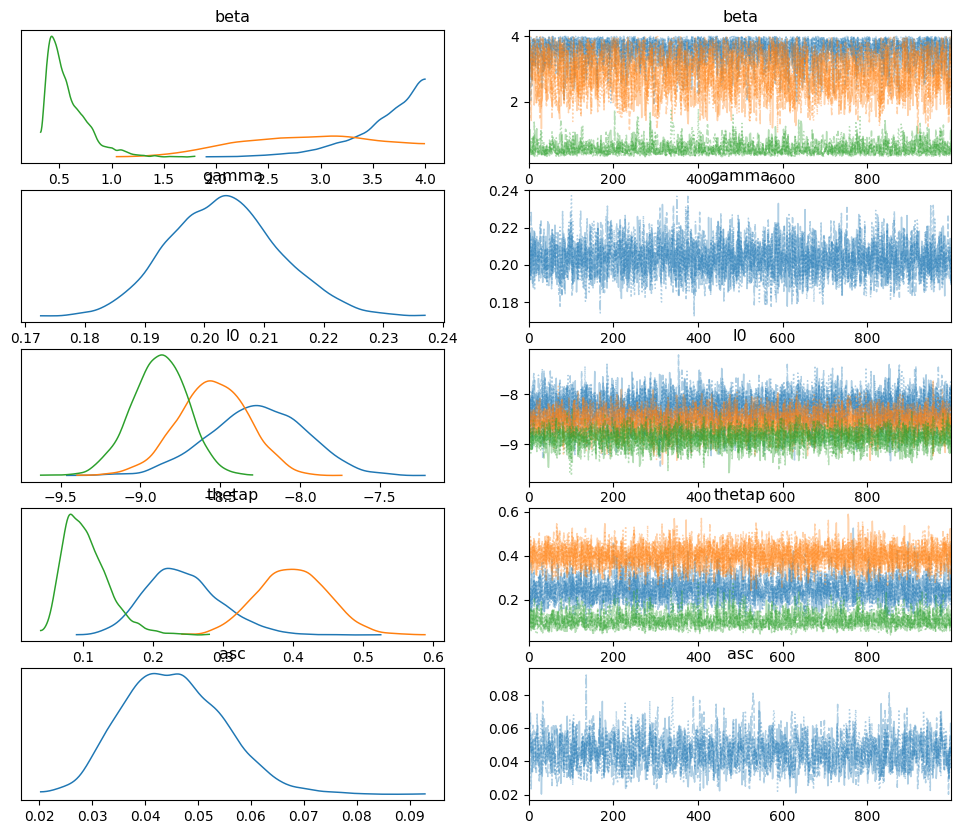

In [5]:
az.plot_trace(fit, var_names=['beta','gamma','I0','thetap','asc'], combined=True)
plt.show()

/tmp/ipykernel_47985/1249498492.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(beta[:, i], hist=False, kde=True,
/home/zxy/mcmc/lib/python3.8/site-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/tmp/ipykernel_47985/1249498492.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or 

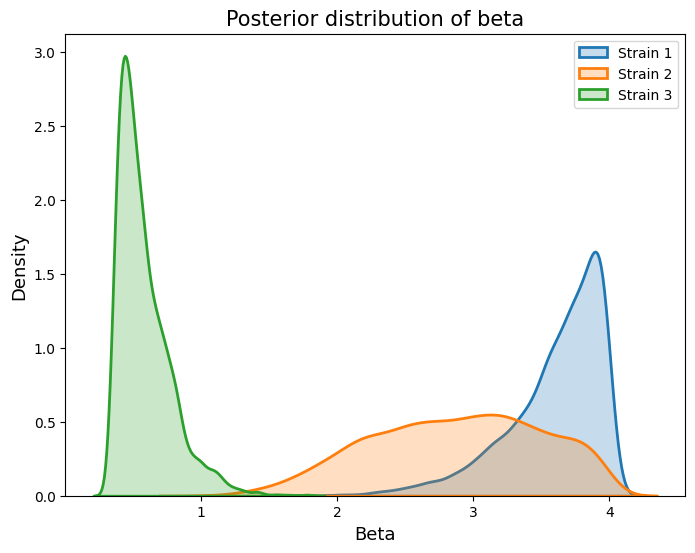

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 提取 beta 参数
beta = multistrain_fit['beta']

# 绘制 beta 参数的后验分布
plt.figure(figsize=(8, 6))
for i in range(beta.shape[1]):
    sns.distplot(beta[:, i], hist=False, kde=True,
        kde_kws = {'shade': True, 'linewidth': 2},
        label='Strain '+str(i+1))

plt.xlabel('Beta', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.title('Posterior distribution of beta', fontsize=15)
plt.legend()
plt.show()

/tmp/ipykernel_47985/3576070586.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(thetap[i], hist=False, kde=True,
/home/zxy/mcmc/lib/python3.8/site-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/tmp/ipykernel_47985/3576070586.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `

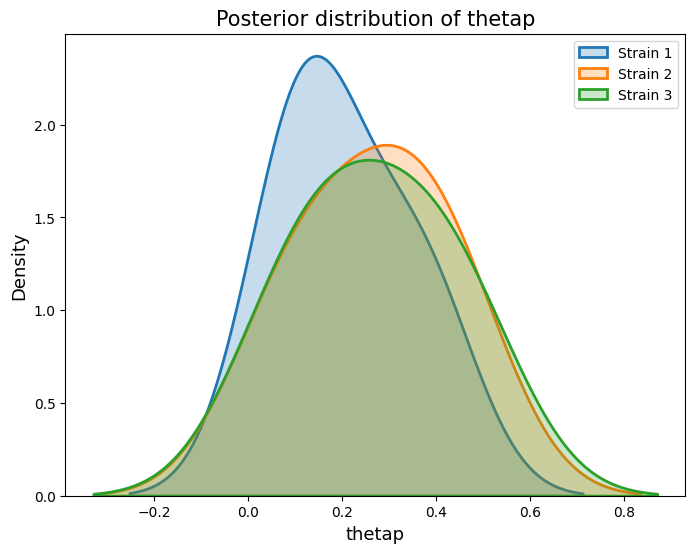

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 提取 beta 参数
thetap = multistrain_fit['thetap']

# 绘制 beta 参数的后验分布
plt.figure(figsize=(8, 6))
for i in range(beta.shape[1]):
    sns.distplot(thetap[i], hist=False, kde=True,
        kde_kws = {'shade': True, 'linewidth': 2},
        label='Strain '+str(i+1))

plt.xlabel('thetap', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.title('Posterior distribution of thetap', fontsize=15)
plt.legend()
plt.show()

# 提取 beta 参数



In [ ]:
I0  = multistrain_fit['I0']

# 绘制 beta 参数的后验分布
plt.figure(figsize=(8, 6))
for i in range(beta.shape[1]):
    sns.distplot(I0[i], hist=False, kde=True,
        kde_kws = {'shade': True, 'linewidth': 2},
        label='Strain '+str(i+1))

plt.xlabel('I0 ', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.title('Posterior distribution of I0 ', fontsize=15)
plt.legend()
plt.show()

In [64]:
print(Y_df.columns)

Index(['H1', 'H3', 'B', 'Neg', 'Total'], dtype='object')


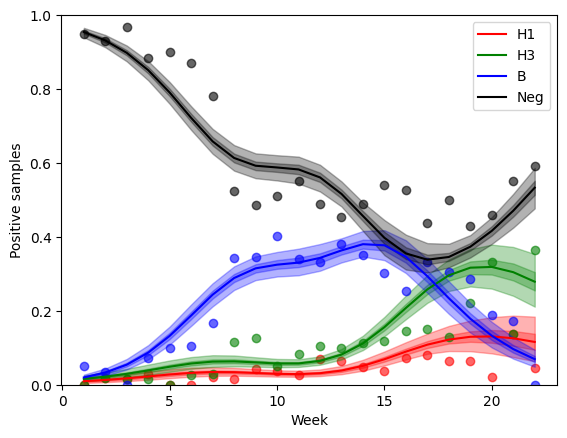

In [8]:
Y_df = pd.DataFrame(data_lst['Y'], columns=["H1", "H3", "B", "Neg"])

# Calculate total for each week in Y_df
Y_df['Total'] = Y_df.sum(axis=1)

# Divide the counts by total to get proportions
Y_df[["H1", "H3", "B", "Neg"]] = Y_df[["H1", "H3", "B", "Neg"]].divide(Y_df['Total'], axis=0)
# Transform Y_df to long format for plotting
Y_df_long = Y_df.reset_index().melt(id_vars='index', value_vars=["H1", "H3", "B", "Neg"],
var_name='Subtype', value_name='value')


# Move the "subtypes" axis to the first dimension and flatten the array
np_week_values = np.moveaxis(multistrain_fit['pPILI'], -1, 0).reshape(4, -1)

# Create labels for 'np', 'week', and 'subtype'
subtype_labels = np.repeat(["H1", "H3", "B", "Neg"], multistrain_fit['pPILI'].shape[0] * multistrain_fit['pPILI'].shape[1])
np_labels = np.tile(np.repeat(np.arange(1, multistrain_fit['pPILI'].shape[0]+1), multistrain_fit['pPILI'].shape[1]), 4)
week_labels = np.tile(np.arange(1, multistrain_fit['pPILI'].shape[1]+1), multistrain_fit['pPILI'].shape[0] * 4)

pPILI_df = pd.DataFrame({
'np': np_labels,
'week': week_labels,
'Subtype': subtype_labels,
'value': np_week_values.flatten()
})
# Calculate the quantiles
pred_viro_df_grouped = pPILI_df.groupby(['week', 'Subtype'])
pred_viro_quantiles = pred_viro_df_grouped['value'].quantile([0.025, 0.25, 0.5, 0.75, 0.975]).unstack().reset_index()
pred_viro_quantiles.columns = ['week', 'Subtype', 'q025', 'q25', 'q50', 'q75', 'q975']

# Convert Y_df to long format
Y_df = Y_df.reset_index().melt(id_vars='index', value_vars=['H1', 'H3', 'B', 'Neg'], var_name='Subtype', value_name='value')

# Plotting
fig, ax = plt.subplots()
colors = {'H1': 'r', 'H3': 'g', 'B': 'b', 'Neg': 'black'}
for subtype, color in colors.items():
    data = pred_viro_quantiles[pred_viro_quantiles.Subtype == subtype]
    ax.plot(data.week, data.q50, color=color, label=subtype)
    ax.fill_between(data.week, data.q025, data.q975, color=color, alpha=0.3)
    ax.fill_between(data.week, data.q25, data.q75, color=color, alpha=0.3)
    #Y_data = Y_df[Y_df.Subtype == subtype]
    
    observed_data = Y_df_long[Y_df_long.Subtype == subtype]
    ax.scatter(observed_data['index']+1, observed_data['value'], color=color, alpha=0.6)

ax.set_ylim([0, 1])
ax.set_xlabel('Week')
ax.set_ylabel('Positive samples')
ax.legend()
plt.show()

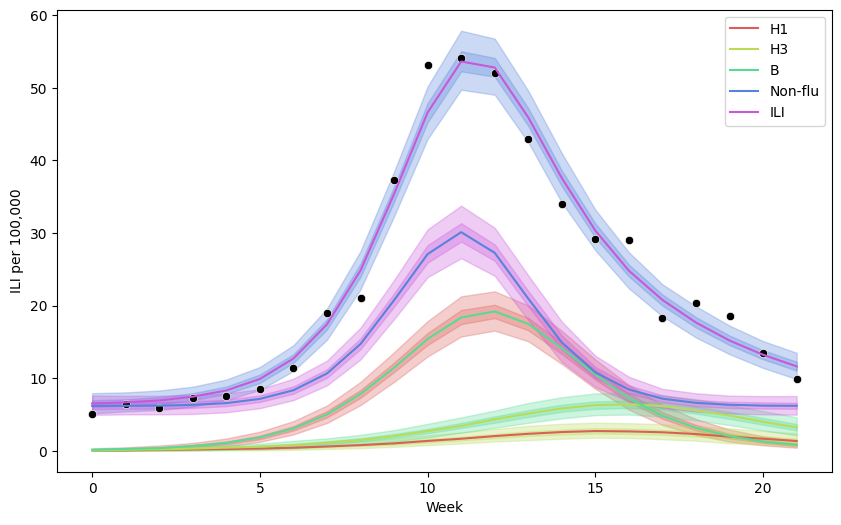

In [9]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_lst is already defined
# First, convert YILI from numpy array to pandas DataFrame
ili_df = pd.DataFrame(data_lst['YILI'], columns=['ILI', 'ILIMon'])

# Add 'value' and 'week' columns
ili_df['value'] = ili_df['ILI'] * 100000 / ili_df['ILIMon']
ili_df['week'] = np.arange(len(ili_df))

# Assuming multistrain_fit is already defined
# Convert 'asc' from numpy array to pandas DataFrame
# Here we assume multistrain_fit['asc'] is a 1-D numpy array
asc_df = pd.DataFrame(multistrain_fit['asc'], columns=['asc'])

# Add 'np' column, we use np.arange for creating an array of increasing numbers
# because row_number() in R creates an array of increasing numbers from 1 to length of the data
asc_df['np'] = np.arange(len(asc_df))

# We should now have the 'ili_df' and 'asc_df' dataframes similar to R script
# Convert 'PILI' from 3D numpy array to pandas DataFrame
pili_data = []
for i in range(multistrain_fit['PILI'].shape[0]):
    for j in range(multistrain_fit['PILI'].shape[1]):
        for k in range(multistrain_fit['PILI'].shape[2]):
            pili_data.append([i, j, k, multistrain_fit['PILI'][i, j, k]])
df_pili = pd.DataFrame(pili_data, columns=['np', 'Subtype', 'week', 'value'])

# Convert 'NILI' from 2D numpy array to pandas DataFrame
nili_data = []
for i in range(multistrain_fit['NILI'].shape[0]):
    for j in range(multistrain_fit['NILI'].shape[1]):
        nili_data.append([i, j, multistrain_fit['NILI'][i, j]])
df_nili = pd.DataFrame(nili_data, columns=['np', 'week', 'value'])


# Convert 'Subtype' in df_pili to categories
df_pili['Subtype'] = pd.Categorical(df_pili['Subtype'], categories=[0, 1, 2], ordered=True)

# Rename category codes with actual labels
df_pili['Subtype'] = df_pili['Subtype'].cat.rename_categories(['H1', 'H3', 'B'])

# Set 'Subtype' in df_nili to 'Non-flu'
df_nili['Subtype'] = 'Non-flu'

# Concatenate the two DataFrames
df = pd.concat([df_pili, df_nili], ignore_index=True)

# Join 'ili_df' with 'df' on 'week'
df = pd.merge(df, ili_df[['week', 'ILIMon']], on='week')

# Update 'value'
df['value'] = df['value'] * df['ILIMon'] / data_lst['N']

# Join 'asc_df' with 'df' on 'np'
df = pd.merge(df, asc_df, on='np')

# Generate random binomial numbers
df['pred'] = np.random.binomial(n=np.round(df['value']), p=df['asc'])

# Update 'value'
df['value'] = df['pred'] * 100000 / df['ILIMon']

# Group by 'np' and 'week', and calculate the sum of 'value'
pred_ili_df = df.groupby(['np', 'week'], as_index=False).agg({'value': 'sum'})

# Add 'Subtype' column
pred_ili_df['Subtype'] = 'ILI'

# Concatenate 'pred_ili_df' to 'df'
df = pd.concat([df, pred_ili_df], ignore_index=True)

# Group by 'Subtype' and 'week', and calculate quantiles of 'value'
df_quantiles = df.groupby(['Subtype', 'week']).agg(
q025 = ('value', lambda x: np.quantile(x, 0.025)),
q25 = ('value', lambda x: np.quantile(x, 0.25)),
q50 = ('value', 'median'),
q75 = ('value', lambda x: np.quantile(x, 0.75)),
q975 = ('value', lambda x: np.quantile(x, 0.975)),
).reset_index()

# Set 'Subtype' to category with specific order
df_quantiles['Subtype'] = pd.Categorical(df_quantiles['Subtype'], categories=['H1', 'H3', 'B', 'Non-flu', 'ILI'], ordered=True)


# Set the figure size
plt.figure(figsize=(10, 6))

# Define color palette
palette = sns.color_palette("hls", len(df_quantiles['Subtype'].unique()))

# Plot ribbons for quantile ranges
for i, subtype in enumerate(df_quantiles['Subtype'].unique()):
    df_subtype = df_quantiles[df_quantiles['Subtype'] == subtype]
    plt.fill_between(df_subtype['week'], df_subtype['q025'], df_subtype['q975'], color=palette[i], alpha=.3)
    plt.fill_between(df_subtype['week'], df_subtype['q25'], df_subtype['q75'], color=palette[i], alpha=.3)

# Plot lines for median values
sns.lineplot(data=df_quantiles, x='week', y='q50', hue='Subtype', palette=palette)

# Plot points for ili_df values
sns.scatterplot(data=ili_df, x='week', y='value', color='black')

# Set labels
plt.xlabel('Week')
plt.ylabel('ILI per 100,000')

# Show the plot
plt.show()

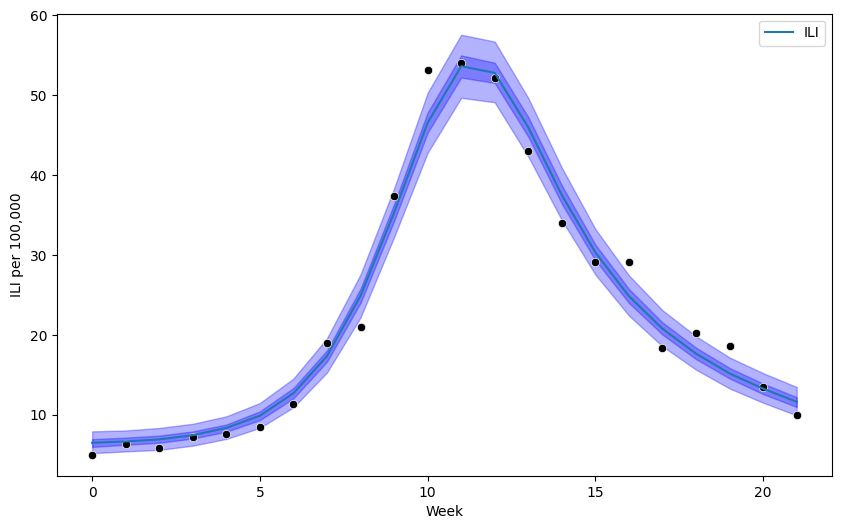

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data_lst and multistrain_fit are already defined

# Convert YILI from numpy array to pandas DataFrame
ili_df = pd.DataFrame(data_lst['YILI'], columns=['ILI', 'ILIMon'])
ili_df['value'] = ili_df['ILI'] * 100000 / ili_df['ILIMon']
ili_df['week'] = np.arange(len(ili_df))

# Convert 'asc' from numpy array to pandas DataFrame
asc_df = pd.DataFrame(multistrain_fit['asc'], columns=['asc'])
asc_df['np'] = np.arange(len(asc_df))

# Convert PILI from 3D numpy array to pandas DataFrame
pili_data = []
for i in range(multistrain_fit['PILI'].shape[0]):
    for j in range(multistrain_fit['PILI'].shape[1]):
        for k in range(multistrain_fit['PILI'].shape[2]):
            pili_data.append([i, j, k, multistrain_fit['PILI'][i, j, k]])
df_pili = pd.DataFrame(pili_data, columns=['np','Subtype', 'week',  'value'])

# Convert NILI from 2D numpy array to pandas DataFrame
nili_data = []
for i in range(multistrain_fit['NILI'].shape[0]):
    for j in range(multistrain_fit['NILI'].shape[1]):
        nili_data.append([i, j, multistrain_fit['NILI'][i, j]])
df_nili = pd.DataFrame(nili_data, columns=['np', 'week', 'value'])

# Convert 'Subtype' in df_pili to categories
df_pili['Subtype'] = pd.Categorical(df_pili['Subtype'], categories=[0, 1, 2], ordered=True)
df_pili['Subtype'] = df_pili['Subtype'].cat.rename_categories(['H1', 'H3', 'B'])

# Set 'Subtype' in df_nili to 'Non-flu'
df_nili['Subtype'] = 'Non-flu'

# Concatenate the two DataFrames
df = pd.concat([df_pili, df_nili], ignore_index=True)

# Join 'ili_df' with 'df' on 'week'
df = pd.merge(df, ili_df[['week', 'ILIMon']], on='week')

# Update 'value' to cases per 100,000
df['value'] = df['value'] * df['ILIMon'] / data_lst['N']

# Join 'asc_df' with 'df' on 'np'
df = pd.merge(df, asc_df, on='np')

# Generate random binomial numbers
df['pred'] = np.random.binomial(n=np.round(df['value']), p=df['asc'])

# Update 'value' to cases per 100,000
df['value'] = df['pred']*100000/df['ILIMon']

# Group by 'np' and 'week', and calculate the sum of 'value'
pred_ili_df = df.groupby(['np', 'week'], as_index=False).agg({'value': 'sum'})

# Add 'Subtype' column
pred_ili_df['Subtype'] = 'ILI'

# Group by 'Subtype' and 'week', and calculate quantiles of 'value'
df_quantiles = pred_ili_df.groupby(['week']).agg(
q025 = ('value', lambda x: np.quantile(x, 0.025)),
q25 = ('value', lambda x: np.quantile(x, 0.25)),
q50 = ('value', 'median'),
q75 = ('value', lambda x: np.quantile(x, 0.75)),
q975 = ('value', lambda x: np.quantile(x, 0.975)),
).reset_index()

# Add 'Subtype' column
df_quantiles['Subtype'] = 'ILI'

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot ribbons for quantile ranges
plt.fill_between(df_quantiles['week'], df_quantiles['q025'], df_quantiles['q975'], color='blue', alpha=.3)
plt.fill_between(df_quantiles['week'], df_quantiles['q25'], df_quantiles['q75'], color='blue', alpha=.3)

# Plot lines for median values
sns.lineplot(data=df_quantiles, x='week', y='q50', hue='Subtype')

# Plot points for ili_df values
sns.scatterplot(data=ili_df, x='week', y='value', color='black')

# Set labels
plt.xlabel('Week')
plt.ylabel('ILI per 100,000')

# Show the plot
plt.show()

In [98]:
print(df['ILIMon'])

0         1538344
1         1538344
2         1538344
3         1538344
4         1679119
           ...   
703995    1754597
703996    1712244
703997    1712244
703998    1712244
703999    1712244
Name: ILIMon, Length: 704000, dtype: int64


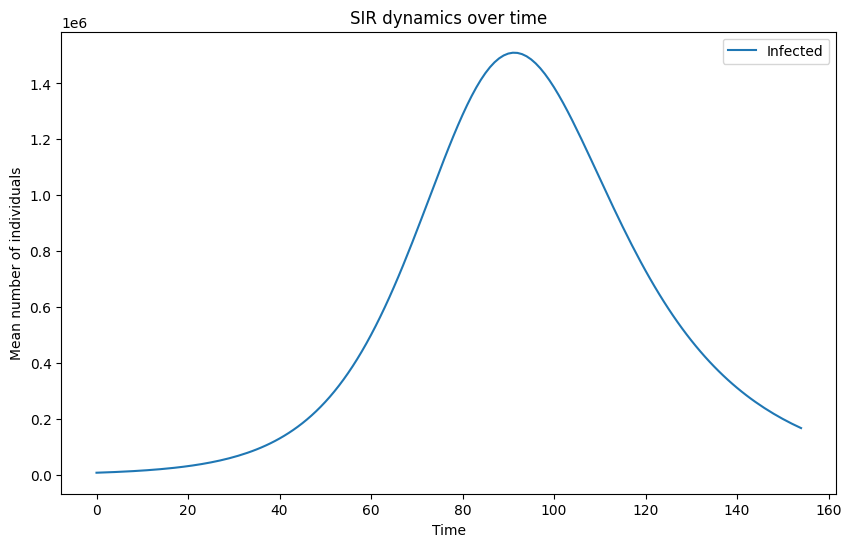

In [10]:
import numpy as np
import matplotlib.pyplot as plt

I_samples = multistrain_fit['I'] # 提取感染者样本
S_samples = multistrain_fit['S'] # 提取易感人群样本
R_samples = multistrain_fit['R'] # 提取移出者样本

# 计算每个时间点的平均感染人数、易感人数和移出人数
mean_infections = np.mean(np.sum(I_samples, axis=1), axis=0)
mean_susceptibles = np.mean(np.sum(S_samples, axis=1), axis=0)
mean_recovereds = np.mean(np.sum(R_samples, axis=1), axis=0)

plt.figure(figsize=(10, 6))

# 绘制每个时间点的平均感染人数、易感人数和移出人数
#plt.plot(mean_susceptibles, label='Susceptible')
plt.plot(mean_infections, label='Infected')
#plt.plot(mean_recovereds, label='Recovered')

plt.xlabel('Time')
plt.ylabel('Mean number of individuals')
plt.title('SIR dynamics over time')
plt.legend()

plt.show()

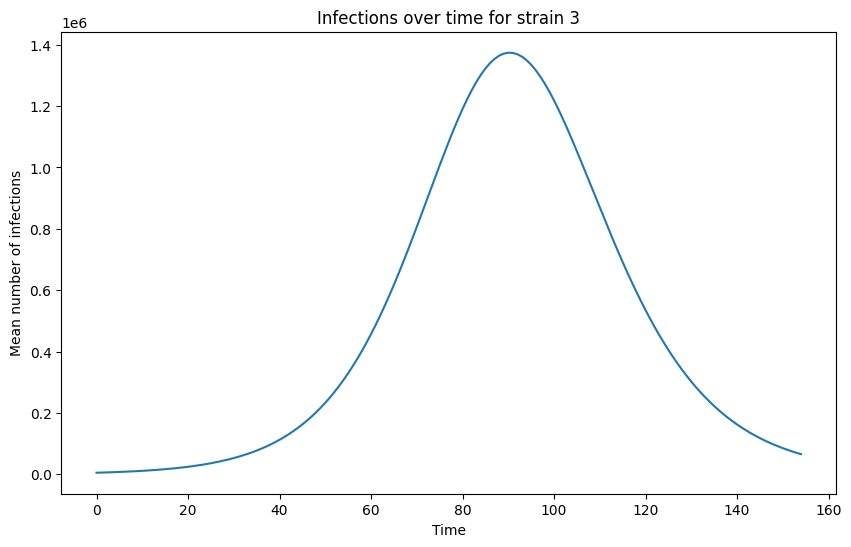

In [12]:
import numpy as np
import matplotlib.pyplot as plt

I_samples = multistrain_fit['I'] # 提取样本

# 假设我们想要查看第一个菌株的感染人数
strain = 2
infections = I_samples[:, strain, :]

# 计算每个时间点的平均感染人数
mean_infections = np.mean(infections, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(mean_infections)
plt.xlabel('Time')
plt.ylabel('Mean number of infections')
plt.title('Infections over time for strain {}'.format(strain+1))
plt.show()

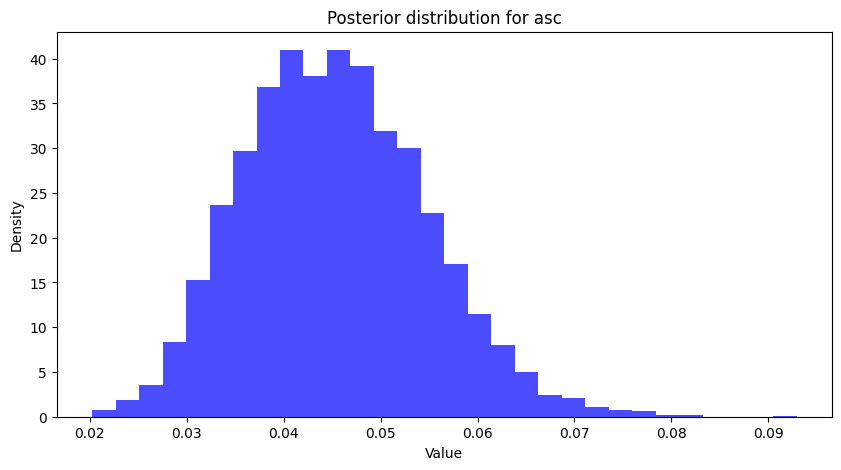

In [13]:
import matplotlib.pyplot as plt

# 提取'asc'的结果
asc_samples = multistrain_fit['asc']

# 生成一个直方图
plt.figure(figsize=(10, 5))
plt.hist(asc_samples, bins=30, color='blue', alpha=0.7, density=True)
plt.title(f'Posterior distribution for asc')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

In [5]:
print(multistrain_fit['ILI'])

[[  34958.23247284   73882.93615142  155787.10215    ... 3595047.12188624
  2306359.86504344 1477503.10541837]
 [  34973.59893322   74005.03937749  156233.4016786  ... 3665677.99992246
  2357186.395693   1511303.6898974 ]
 [  34991.54395608   74110.27597843  156597.45307008 ... 3732379.57169492
  2405585.03779269 1543625.98036257]
 ...
 [  30093.94677546   57375.40242771  109217.31871593 ... 4166481.31844103
  2712914.52511734 1755866.71350498]
 [  29916.7938522    56899.08467765  108049.73954703 ... 4213478.67158607
  2747649.27488713 1779665.34586811]
 [  30081.36946491   57329.5519431   109088.77938239 ... 4155731.82357075
  2704911.5483965  1750509.01588996]]
